In [132]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload 
reload(sq_ext)

<module 'Modules.SQcircuit_extensions' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\SQcircuit_extensions.py'>

In [133]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

In [163]:
nmax_f = 50
φ_ext_values = 0.5  + np.geomspace(1e-5, 0.5, 100)
n_eig = 40

In [164]:
fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, nmax_f=nmax_f)
H0  = fluxonium.hamiltonian()
E0, ψ0 = sq_ext.diag(H0, n_eig, remove_ground=True, fix_phase=True)

In [207]:
E = np.zeros([len(φ_ext_values), n_eig])
ψ = np.zeros([len(φ_ext_values), nmax_f, n_eig], dtype='complex')
H = np.zeros([len(φ_ext_values), nmax_f, nmax_f], dtype='complex')

loop = fluxonium.loops[0]
for i, φ_ext  in enumerate(φ_ext_values):
    loop.set_flux(φ_ext)
    H[i] = fluxonium.hamiltonian()
    E[i] , ψ[i] = sq_ext.diag(H[i], n_eig, remove_ground=False, fix_phase=True)


In [211]:
overlap = np.zeros([len(φ_ext_values), n_eig, n_eig], dtype='complex')
H_in_ψ0 = np.zeros([len(φ_ext_values), n_eig, n_eig], dtype='complex') 
for i in range(len(φ_ext_values)) :
    overlap[i] = ψ0.conj().T  @ ψ[i]
    H_in_ψ0[i] = overlap[i] @ np.diag(E[i]) @ overlap[i].conj().T
    # H_in_ψ0[i] = ψ0.conj().T @ H[i].__array__() @ ψ0 / 2/ np.pi / 1e9

In [213]:
overlap[0]

array([[ 9.99999998e-01+6.45240882e-16j,  6.30217741e-05+2.50046822e-16j,
         2.18323565e-09+4.56433274e-15j, ...,
        -2.55371605e-16+9.07129135e-17j,  1.73519515e-16+4.81988161e-16j,
         4.46565142e-16-1.62390011e-16j],
       [-6.30217741e-05+1.06704980e-15j,  9.99999997e-01-3.45245699e-16j,
         5.03039980e-05+5.21763682e-15j, ...,
         2.73291802e-17-4.90788975e-17j,  1.73956422e-16-9.21571730e-17j,
        -4.09377746e-16+1.85814631e-16j],
       [ 1.13733731e-09+3.51455047e-15j, -5.03039980e-05+4.29106263e-15j,
         9.99999998e-01-1.09276622e-15j, ...,
        -2.57592934e-16+2.22543238e-16j,  1.95427390e-16-3.13644584e-17j,
         4.37180529e-16+3.93404185e-16j],
       ...,
       [ 1.53407728e-16-5.68557176e-17j, -2.60652357e-16+7.86145754e-17j,
         2.71467885e-16+2.66671351e-16j, ...,
         1.00000000e+00+2.18888043e-13j,  1.46711133e-05+1.69400406e-14j,
         1.35928333e-10+2.01110190e-15j],
       [-6.33635159e-17+2.55590667e-16j, -2.

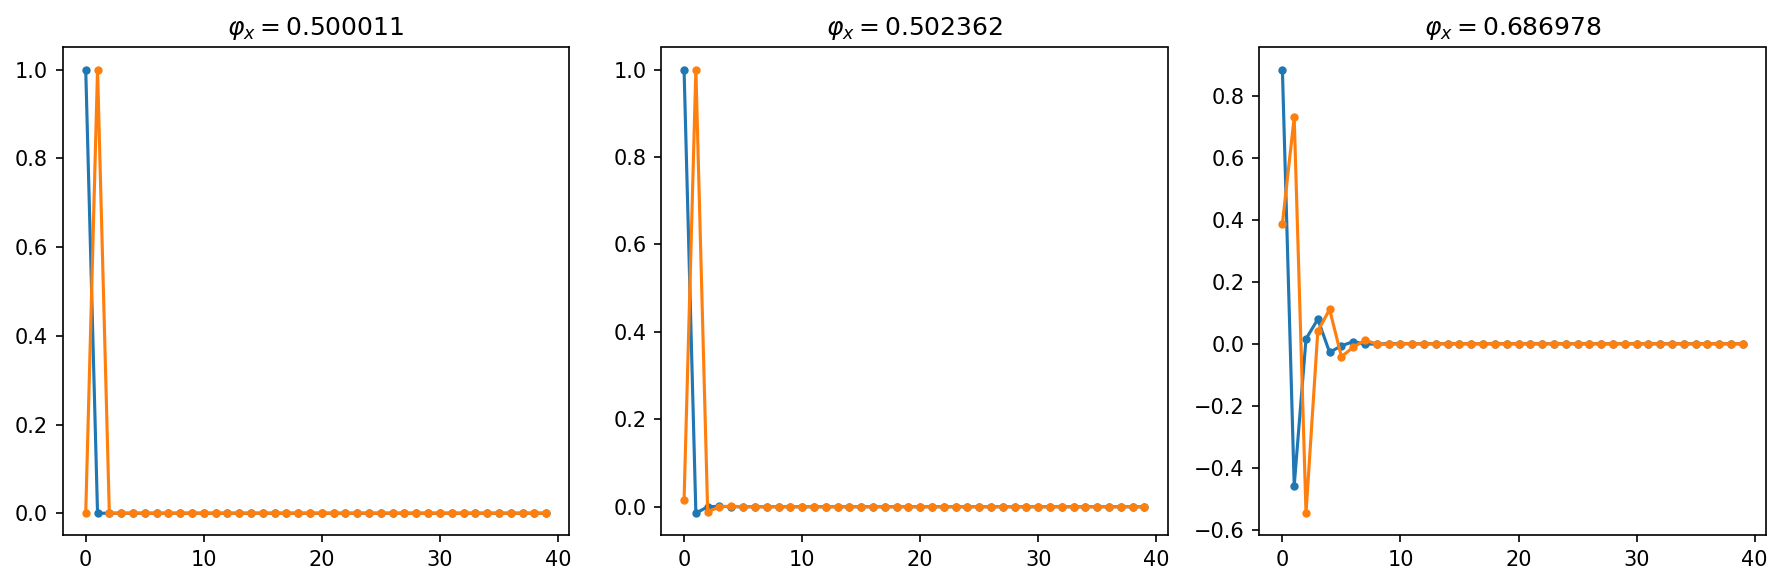

In [128]:
φ_ext_indices = [1, 50, 90]

fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)
for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    ax.plot(overlap[φ_ext_index,:,:2],'.-')
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')

fig.tight_layout()

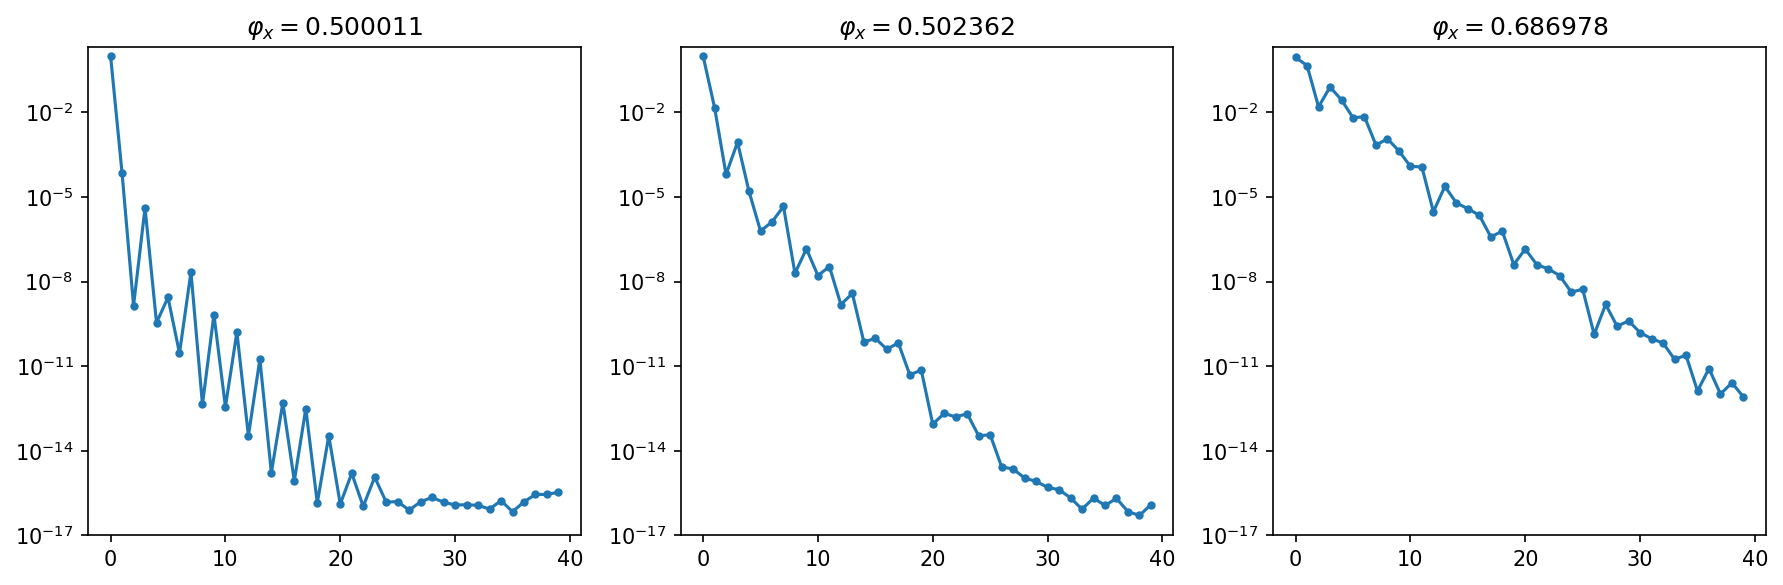

In [131]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    ax.plot(np.abs(overlap[φ_ext_index,:,0]),'.-')
    ax.set_yscale('log')
    ax.set_ylim([1e-17,2])
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    
fig.tight_layout()